In [1]:
import os
import math
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow.keras.utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed,Conv1D, LSTM
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, MaxPooling1D, Reshape

import matplotlib.pyplot as plt
import seaborn as sns
import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
# values were colected every 10 minutes
# slice [start:stop:step], starting from index 5 take every 6th record to subsample every hour
df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [4]:
dataset = df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']].astype(float)
dataset.head()

,T (degC),p (mbar),rho (g/m**3)
5,-8.05,996.50,1307.86
11,-8.88,996.62,1312.25
17,-8.81,996.84,1312.18
23,-9.05,996.99,1313.61
29,-9.63,997.46,1317.19


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

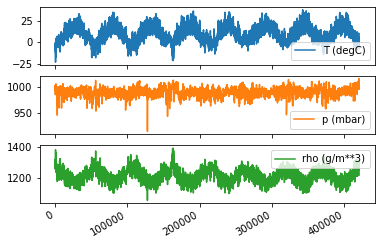

In [5]:
dataset.plot(subplots=True)

In [6]:
# multi variables
cols = list(dataset)
cols

['T (degC)', 'p (mbar)', 'rho (g/m**3)']

In [78]:
# Preprocessing + reshape dataset  (time, var, values, channel=1)
scaler =  MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset[:5000].values.reshape(-1, len(cols)))
scaled_data.shape

(5000, 3)

In [79]:
display(pd.DataFrame(scaled_data, columns = cols).head())

,T (degC),p (mbar),rho (g/m**3)
0,0.291403,0.850272,0.701596
1,0.274960,0.852248,0.719241
2,0.276347,0.855872,0.718960
3,0.271593,0.858343,0.724708
4,0.260103,0.866085,0.739097


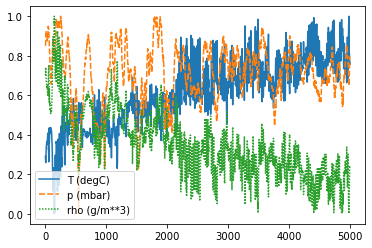

In [80]:
sns.lineplot(data=pd.DataFrame(scaled_data))
plt.legend(labels=cols)

In [81]:
# Split train/test data
train_dataset, test_dataset = np.vsplit(scaled_data, [int(len(dataset[:5000])*0.8)])
train_dataset.shape, test_dataset.shape

((4000, 3), (1000, 3))

In [82]:
train_datasetEX = np.expand_dims(train_dataset, axis = 2)
train_datasetEX.shape

(4000, 3, 1)

In [83]:
x_train = []
y_train = []

# use 7 days for prediction = 1h*24*7 = 168, predict next day = 1h*24 = 24
n_future = 24
n_past = 168

for i in range(n_past, len(train_dataset)-n_future+1):
    x_train.append(train_datasetEX[i-n_past:i, 0:train_dataset.shape[1]])
    y_train.append(train_dataset[i+n_future-1:i+n_future, 0:train_dataset.shape[1]])

In [84]:
x_train, y_train = np.array(x_train), np.array(y_train)


In [85]:

x_train.shape, y_train.shape 

((3809, 168, 3, 1), (3809, 1, 3))

In [86]:
model = Sequential()
# (batch_size, n_timesteps, n_features, channel)
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, padding = 'same', activation="relu"), input_shape=(None, x_train.shape[2], x_train.shape[3])))
# (batch_size, n_timesteps, n_features, n_filter)
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
# (batch_size, n_timesteps, n_features, n_filter)
model.add(TimeDistributed(Flatten()))
# (batch_size, n_timesteps, n_features*n_filter)


# LSTM layer
model.add(LSTM(32, return_sequences=True))
# (batch_size, n_timesteps, units)
model.add(Dropout(0.2))
model.add(LSTM(y_train.shape[2], return_sequences=False))
# (batch_size, units=y_train.shape[2])
model.add(Reshape([1, y_train.shape[2]]))
# (batch_size, 1, n_features)

model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mse'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_48 (TimeDis (None, None, 3, 32)       128       
_________________________________________________________________
time_distributed_49 (TimeDis (None, None, 3, 32)       0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, None, 3, 32)       0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, None, 96)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, None, 32)          16512     
_________________________________________________________________
dropout_34 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 3)                

In [87]:
history = model.fit(x_train, y_train, epochs = 20, batch_size=16,
                    validation_split=0.20, verbose=1, shuffle = False)

Epoch 1/20
191/191 [==============================] - 50s 134ms/step - loss: 0.0200 - mse: 0.0401 - val_loss: 0.0044 - val_mse: 0.0087
Epoch 2/20
191/191 [==============================] - 26s 135ms/step - loss: 0.0099 - mse: 0.0198 - val_loss: 0.0039 - val_mse: 0.0078
Epoch 3/20
191/191 [==============================] - 27s 140ms/step - loss: 0.0091 - mse: 0.0183 - val_loss: 0.0037 - val_mse: 0.0075
Epoch 4/20
191/191 [==============================] - 27s 141ms/step - loss: 0.0081 - mse: 0.0162 - val_loss: 0.0035 - val_mse: 0.0071
Epoch 5/20
191/191 [==============================] - 27s 141ms/step - loss: 0.0073 - mse: 0.0145 - val_loss: 0.0033 - val_mse: 0.0067
Epoch 6/20
191/191 [==============================] - 27s 142ms/step - loss: 0.0066 - mse: 0.0133 - val_loss: 0.0030 - val_mse: 0.0060
Epoch 7/20
191/191 [==============================] - 27s 141ms/step - loss: 0.0061 - mse: 0.0122 - val_loss: 0.0029 - val_mse: 0.0057
Epoch 8/20
191/191 [==============================] - 2

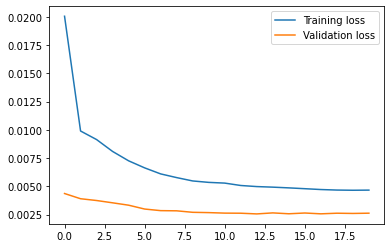

In [88]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [89]:
# get predictions for training data
train_future = model.predict(x_train[-n_future:])
train_past = model.predict(x_train[n_past:])
y_pred_future = scaler.inverse_transform(train_future.reshape(-1, x_train.shape[2]))
y_pred_train = scaler.inverse_transform(train_past.reshape(-1, x_train.shape[2]))

y_pred_future.shape, y_pred_train.shape


((24, 3), (3641, 3))

In [111]:
actual_data = np.array(dataset[:4000-(2*n_past+n_future)+1])
actual_data.shape

(3641, 3)

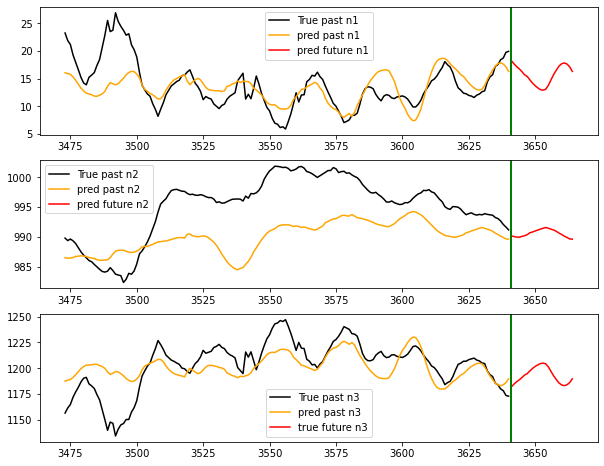

In [113]:
# plot
a_axis = np.arange(len(y_pred_train)-n_past, len(y_pred_train))
b_axis = np.arange(len(y_pred_train), len(y_pred_train)+len(y_pred_future))

plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(a_axis, actual_data[-n_past:,0], color = 'black', label ='True past n1')
plt.plot(a_axis, y_pred_train[-n_past:,0], color = 'orange', label ='pred past n1')
plt.plot(b_axis, y_pred_future[:,0], color = 'red', label ='pred future n1')
plt.axvline(x = len(y_pred_train), color='green', linewidth=2, linestyle='-')
plt.legend()

plt.subplot(3,1,2)
plt.plot(a_axis, actual_data[-n_past:,1], color = 'black', label ='True past n2')
plt.plot(a_axis, y_pred_train[-n_past:,1], color = 'orange', label ='pred past n2')
plt.plot(b_axis, y_pred_future[:,1], color = 'red', label ='pred future n2')
plt.axvline(x = len(y_pred_train), color='green', linewidth=2, linestyle='-')
plt.legend()

plt.subplot(3,1,3)
plt.plot(a_axis, actual_data[-n_past:,2], color = 'black', label ='True past n3')
plt.plot(a_axis, y_pred_train[-n_past:,2], color = 'orange', label ='pred past n3')
plt.plot(b_axis, y_pred_future[:,2], color = 'red', label ='true future n3')
plt.axvline(x = len(y_pred_train), color='green', linewidth=2, linestyle='-')
plt.legend()

plt.show()


In [114]:
# Calculate Training RMSE Value
trainScore1 = math.sqrt(mean_squared_error(actual_data[-n_past:,0], y_pred_train[-n_past:,0]))
print('n1: Train Score: %.2f RMSE' % (trainScore1))
trainScore2 = math.sqrt(mean_squared_error(actual_data[-n_past:,1], y_pred_train[-n_past:,1]))
print('n2: Train Score: %.2f RMSE' % (trainScore2))
trainScore3 = math.sqrt(mean_squared_error(actual_data[-n_past:,2], y_pred_train[-n_past:,2]))
print('n3: Train Score: %.2f RMSE' % (trainScore3))

n1: Train Score: 3.41 RMSE
n2: Train Score: 6.48 RMSE
n3: Train Score: 18.77 RMSE


In [115]:
# forecast
test_datasetEX = np.expand_dims(test_dataset, axis = 2)
test_datasetEX.shape

x_test = []
y_test = []

for i in range(n_past, len(test_dataset)-n_future+1):
    x_test.append(test_datasetEX[i-n_past:i, 0:test_dataset.shape[1]])
    y_test.append(test_dataset[i+n_future-1:i+n_future, 0:test_dataset.shape[1]])
    
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((809, 168, 3, 1), (809, 1, 3))

In [116]:
forecast = model.predict(x_test)

In [117]:
forecast.shape

(809, 1, 3)

In [121]:
# denormalize the predicted values

predicted = scaler.inverse_transform(forecast.reshape(-1, x_test.shape[2]))
predicted.shape

(809, 3)

In [122]:
train_unscaled = scaler.inverse_transform(y_train.reshape(-1, x_test.shape[2]))
test_unscaled = scaler.inverse_transform(y_test.reshape(-1, x_test.shape[2]))

In [123]:
train_unscaled.shape,test_unscaled.shape

((3809, 3), (809, 3))

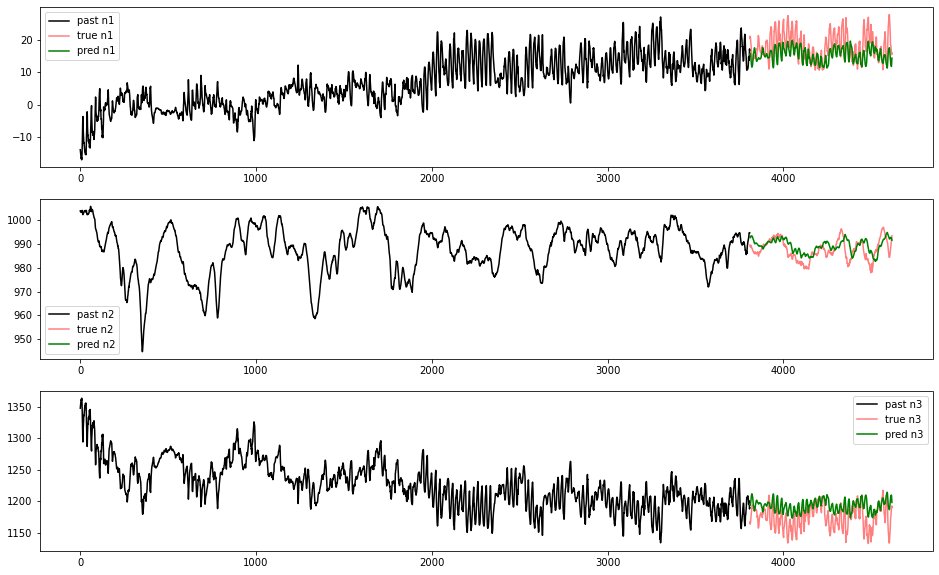

In [125]:
# Check Predictions

a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train)+len(y_test))

plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(a_axis, train_unscaled[:,0], color = 'black', label ='past n1')
plt.plot(b_axis, test_unscaled[:,0], color = 'red', alpha=0.5, label ='true n1')
plt.plot(b_axis, predicted[:len(y_test),0], color = 'green', label ='pred n1')
plt.legend()

plt.subplot(3,1,2)
plt.plot(a_axis, train_unscaled[:,1], color = 'black', label ='past n2')
plt.plot(b_axis, test_unscaled[:,1], color = 'red', alpha=0.5, label ='true n2')
plt.plot(b_axis, predicted[:len(y_test),1], color = 'green', label ='pred n2')
plt.legend()

plt.subplot(3,1,3)
plt.plot(a_axis, train_unscaled[:,2], color = 'black', label ='past n3')
plt.plot(b_axis, test_unscaled[:,2], color = 'red', alpha=0.5, label ='true n3')
plt.plot(b_axis, predicted[:len(y_test),2], color = 'green', label ='pred n3')
plt.legend()


plt.show()


In [126]:
# Calculate RMSE Value

testScore = math.sqrt(mean_squared_error(test_unscaled[:200,0], predicted[:200,0]))
print('n1 Test Score: %.2f RMSE' % (testScore))
testScore = math.sqrt(mean_squared_error(test_unscaled[:200,1], predicted[:200,1]))
print('n2 Test Score: %.2f RMSE' % (testScore))
testScore = math.sqrt(mean_squared_error(test_unscaled[:200,2], predicted[:200,2]))
print('n3 Test Score: %.2f RMSE' % (testScore))

n1 Test Score: 3.97 RMSE
n2 Test Score: 2.53 RMSE
n3 Test Score: 21.35 RMSE
